In [146]:
"""
@author: bangfu.tao
"""

import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import time
from datetime import datetime


In [147]:
# convert data from tab format to csv format
f0 = open("data-input-tab.txt", "r")
f1 = open("output.txt", "w")
for x0 in f0:
    x1 = x0.replace('\t', ',')
    f1.write(x1)
        
f0.close()
f1.close()


In [148]:
raw_df = pd.read_csv("data-input-csv.txt")
#raw_df.head(10)

In [149]:
def datetime2sec(dt):
    obj = datetime.strptime(dt, "%d/%m/%Y %H:%M:%S")
    return obj.timestamp()

def date2sec(dt):
    obj = datetime.strptime(dt, "%d/%m/%Y")
    return obj.timestamp()

#a = datetime2sec("25/09/2018 13:30:00")
#b = date2sec("25/09/2018")
#print((a-b)/3600)

In [150]:
core_df = raw_df.loc[:, ['ticket #', 'checkout date', 'checkin date', 'Unit #', 'miles drive']]

In [151]:
#core_df.head(10)

In [152]:
bad_rows = []
for i in range(core_df.shape[0]):
    row = core_df.iloc[i, :]
    dt0 = datetime2sec(row[1].strip())
    dt1 = datetime2sec(row[2].strip())
    unit = row[3]
    miles = row[4]

    if not (dt0 > 0 and dt1 > dt0 and unit > 0 and miles >0):
        bad_rows.append(i)
        print(row)
    
if (len(bad_rows) > 0):
    core_df.drop(bad_rows, inplace = True)

ticket #                  1010699905
checkout date    14/01/2020 13:21:00
checkin date     15/01/2020 08:26:00
Unit #                      87193185
miles drive                        0
Name: 29921, dtype: object


In [153]:
core_df['out-date-only'] = [ x[0:10].strip() for x in core_df['checkout date'] ] 
core_df['out-date-only-mins'] = [ date2sec(x.strip())/60 for x in core_df['out-date-only'] ] 

core_df['in-date-only'] = [ x[0:10].strip() for x in core_df['checkin date'] ] 
core_df['in-date-only-mins'] = [ date2sec(x.strip())/60 for x in core_df['in-date-only'] ] 


In [154]:
core_df['out-datetime-mins'] = [ datetime2sec(x.strip())/60 for x in core_df['checkout date'] ] 
core_df['in-datetime-mins'] = [ datetime2sec(x.strip())/60 for x in core_df['checkin date'] ]
core_df['rental-minutes'] = core_df["in-datetime-mins"] - core_df["out-datetime-mins"]


In [155]:
#core_df.head(10)

In [156]:
#car_sorted_df = core_df.sort_values(by = 'Unit #')
car_sorted_df = core_df.sort_values(['Unit #', 'out-datetime-mins'])  ## two level sorted !!!

In [157]:
#car_sorted_df.head(10)

In [158]:
"""
fp = open("tmp.txt", "w")
tmp = car_sorted_df.to_csv(index=False)  
fp.write(tmp)
fp.close()
""" 

'\nfp = open("tmp.txt", "w")\ntmp = car_sorted_df.to_csv(index=False)  \nfp.write(tmp)\nfp.close()\n'

In [159]:
free_mins = []

for i in range(car_sorted_df.shape[0]):
    curr = car_sorted_df.iloc[i, :]
    free_mins.append(-1.0)
    if (i > 0 and curr['Unit #'] == prev['Unit #']):
        free_mins[-2] = curr['out-datetime-mins'] - prev['in-datetime-mins']
    prev = curr;

car_sorted_df['free-minutes'] = free_mins


In [160]:
#car_sorted_df.head(10)

In [161]:
ret_date_sorted_df = core_df.sort_values(['in-date-only-mins', 'Unit #'])  ## two level sorted !!!

In [162]:
# Q2: per day 
N = ret_date_sorted_df.shape[0]
prev = ret_date_sorted_df.iloc[0, :]
groups = []
a = 0
for i in range(N):
    curr = ret_date_sorted_df.iloc[i, :]
    if (i == 0):
        a = 0
    elif (i < N - 1):
        dt0 = prev['in-date-only']
        dt1 = curr['in-date-only']
        if (dt1 != dt0):
            groups.append((a, i))
            a = i
        #else:
            #print(dt0, dt1)
    else:
        dt0 = prev['in-date-only']
        dt1 = curr['in-date-only']
        if (dt1 != dt0):
            groups.append((a, i))
            groups.append((i, i+1))
        else:
            groups.append((a, i+1))
    prev = curr;
    
print("=== groups ===")    
print(len(groups))

ret_dates = []
ret_cars_list = []
for m, n in groups:
    df = ret_date_sorted_df.iloc[m:n, :]
    
    for dt in df['in-date-only']:
        ret_dates.append(dt)
        break;
    tmp = []    
    for car in df['rental-minutes']:
        tmp.append(car)
    ret_cars_list.append(tmp)
    
print("=== ret_dates ===")    
print(len(ret_dates))

print("=== ret_cars_list ===")    
print(len(ret_cars_list))


=== groups ===
609
=== ret_dates ===
609
=== ret_cars_list ===
609


In [163]:
Q2_df = pd.DataFrame()
Q2_df['return-date'] = ret_dates
Q2_df['num-cars'] = [ len(cars) for cars in ret_cars_list ]
Q2_df['total-minutes'] = [ np.array(cars).sum() for cars in ret_cars_list ]
Q2_df['individual-minutes'] = [ str(cars) for cars in ret_cars_list ]

In [164]:
"""
fp = open("Q2-df.txt", "w")
fp.write("return-date\tnum-cars\ttotal-minutes\tindividual-minutes\n")
N = Q2_df.shape[0]
for i in range(N):
    ds = Q2_df.iloc[i, :]
    text = f"{ds[0]}\t{ds[1]}\t{ds[2]}\t{ds[3]}\n"
    fp.write(text)
fp.close()
"""

'\nfp = open("Q2-df.txt", "w")\nfp.write("return-date\tnum-cars\ttotal-minutes\tindividual-minutes\n")\nN = Q2_df.shape[0]\nfor i in range(N):\n    ds = Q2_df.iloc[i, :]\n    text = f"{ds[0]}\t{ds[1]}\t{ds[2]}\t{ds[3]}\n"\n    fp.write(text)\nfp.close()\n'

In [165]:
"""
Q1_df = car_sorted_df
fp = open("Q1-df.txt", "w")

fp.write("car-unit-id\tout-datetime\tin-datetime\tdrive-miles\trental-minutes\tfree-in-branch-minutes\n")
N = Q1_df.shape[0]
for i in range(N):
    ds = Q1_df.iloc[i, :]
    text = f"{ds['Unit #']}\t{ds['checkout date']}\t{ds['checkin date']}\t{ds['miles drive']}\t{ds['rental-minutes']}\t{ds['free-minutes']}\n"
    fp.write(text)
fp.close()
"""

'\nQ1_df = car_sorted_df\nfp = open("Q1-df.txt", "w")\n\nfp.write("car-unit-id\tout-datetime\tin-datetime\tdrive-miles\trental-minutes\tfree-in-branch-minutes\n")\nN = Q1_df.shape[0]\nfor i in range(N):\n    ds = Q1_df.iloc[i, :]\n    text = f"{ds[\'Unit #\']}\t{ds[\'checkout date\']}\t{ds[\'checkin date\']}\t{ds[\'miles drive\']}\t{ds[\'rental-minutes\']}\t{ds[\'free-minutes\']}\n"\n    fp.write(text)\nfp.close()\n'

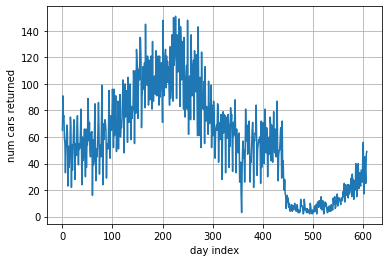

In [166]:
fig = plt.figure()
plt.plot(Q2_df['num-cars'])
plt.grid()
plt.xlabel("day index")
plt.ylabel("num cars returned")
fig.savefig('Q2-test1.png')

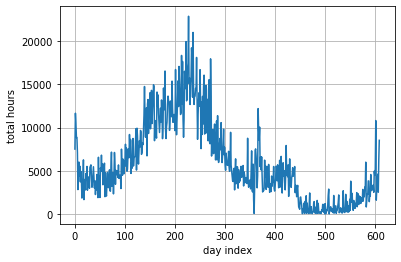

In [167]:
fig = plt.figure()
plt.plot(Q2_df['total-minutes']/60)
plt.grid()
plt.xlabel("day index")
plt.ylabel("total hours")
fig.savefig('Q2-test2.png')

In [168]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


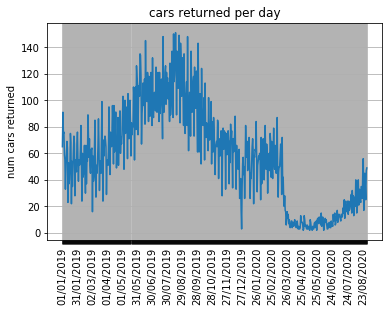

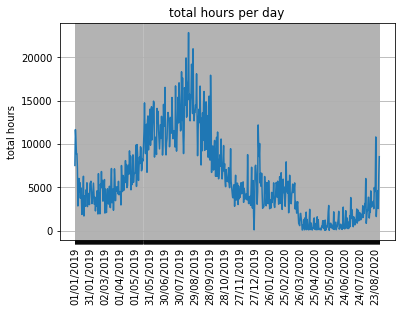

In [169]:
"""
fig = plt.figure()
plt.plot(Q2_df['num-cars'])
plt.grid()
plt.xlabel("day index")
plt.ylabel("num cars returned")
fig.savefig('Q2-test1.png')
"""
fig = plt.figure()
short_dates = list(Q2_df['return-date'])
for i in range(len(short_dates)):
    short_dates[i] = ''
    if (i % 30) == 0:
        short_dates[i] = (Q2_df['return-date'][i]).strip()
            
x=list(range(1, len(Q2_df['return-date'])+1))
plt.xticks(x, short_dates)
plt.plot(x, Q2_df['num-cars'])
plt.ylabel("num cars returned")
plt.grid()
plt.title("cars returned per day")
_=plt.xticks(rotation=90)    
fig.savefig('Q2-test1.png')

##
fig = plt.figure()
x=list(range(1, len(Q2_df['return-date'])+1))
plt.xticks(x, short_dates)
plt.plot(x, Q2_df['total-minutes']/60)  # to hour
plt.ylabel("total hours")
plt.grid()
plt.title("total hours per day")
_=plt.xticks(rotation=90)    
fig.savefig('Q2-test2.png')


In [170]:
#car_sorted_df.head(10)
N = car_sorted_df.shape[0]
prev = car_sorted_df.iloc[0, :]
groups = []
a = 0
for i in range(N):
    curr = car_sorted_df.iloc[i, :]
    if (i == 0):
        a = 0
    elif (i < N - 1):
        dt0 = prev['Unit #']
        dt1 = curr['Unit #']
        if (dt1 != dt0):
            groups.append((a, i))
            a = i
        #else:
            #print(dt0, dt1)
    else:
        dt0 = prev['Unit #']
        dt1 = curr['Unit #']
        if (dt1 != dt0):
            groups.append((a, i))
            groups.append((i, i+1))
        else:
            groups.append((a, i+1))
    prev = curr;
    
print("=== car groups ===")    
print(len(groups))

list_cars = []
list_rental_minutes = []
list_miles = []

for m, n in groups:
    df = car_sorted_df.iloc[m:n, :]
    
    for dt in df['Unit #']:
        list_cars.append(dt)
        break;
    tmp = []    
    for car in df['rental-minutes']:
        tmp.append(car)
    list_rental_minutes.append(np.array(tmp).sum())
    
    tmp = []    
    for car in df['miles drive']:
        tmp.append(car)
    list_miles.append(np.array(tmp).sum())

print("=== list cars ===")    
print(len(list_cars))
    
print("=== list rental minutes ===")    
print(len(list_rental_minutes))

print("=== list miles ===")    
print(len(list_miles))




=== car groups ===
8834
=== list cars ===
8834
=== list rental minutes ===
8834
=== list miles ===
8834


In [171]:
Q1_df = pd.DataFrame()
Q1_df['car-unit'] = list_cars
Q1_df['total-minutes'] = list_rental_minutes
Q1_df['total-miles'] = list_miles
#Q1_df.head(10)


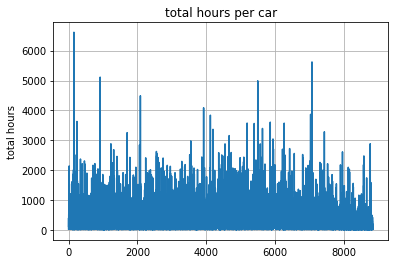

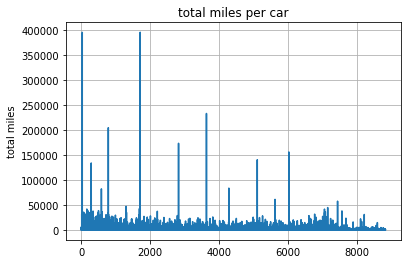

In [172]:
#xstr = list(Q1_df['car-unit'])
#for i in range(len(xstr)):
#    xstr[i] = ''
#    if (i % 30) == 0:
#        xstr[i] = str(Q1_df['car-unit'][i]).strip()
        
fig = plt.figure()
#plt.plot(Q1_df['total-minutes']/60, 'o')  # to hour
plt.plot(Q1_df['total-minutes']/60)  # to hour
plt.ylabel("total hours")
plt.grid()
plt.title("total hours per car")
#_=plt.xticks(rotation=90)    
fig.savefig('Q1-test1.png')

fig = plt.figure()
plt.plot(Q1_df['total-miles']) 
plt.ylabel("total miles")
plt.grid()
plt.title("total miles per car")
#_=plt.xticks(rotation=90)    
fig.savefig('Q1-test2.png')



In [173]:
(Q1_df['total-minutes']/60/24).describe()  # convert to total days per car

count    8834.000000
mean       16.981537
std        19.308998
min         0.015972
25%         4.205382
50%        10.548958
75%        23.293924
max       275.680556
Name: total-minutes, dtype: float64

In [174]:
Q1_df['total-miles'].describe()  # total miles per car

count      8834.000000
mean       2443.132669
std        8527.517907
min           2.000000
25%         457.000000
50%        1046.000000
75%        2324.500000
max      395798.000000
Name: total-miles, dtype: float64

In [175]:
Q2_df['num-cars'].describe()  # returned cars per day

count    609.000000
mean      58.183908
std       37.052714
min        2.000000
25%       25.000000
50%       58.000000
75%       84.000000
max      151.000000
Name: num-cars, dtype: float64

In [176]:
(Q2_df['total-minutes']/60/24).describe()  # returned time (in length of days) per day

count    609.000000
mean     246.329885
std      190.105316
min        1.654861
25%      105.966667
50%      203.676389
75%      364.927083
max      951.838889
Name: total-minutes, dtype: float64